In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
num_epochs = 50
batch_size = 100
learning_rate = 1e-3
reg_lmbd = 1e-4
ksparse = 50

In [3]:
train_dataset = dsets.MNIST(root='data/', 
                            train=True, 
                            transform=transforms.ToTensor(),  
                            download=True)
test_dataset = dsets.MNIST(root='data/', 
                           train=False, 
                           transform=transforms.ToTensor())

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [5]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [75]:
class WinnerTakesAllAutoencoder(nn.Module):
    def __init__(self):
        super(WinnerTakesAllAutoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784,400,bias=False),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(400,784),
            nn.Sigmoid()
        )
        self.ksparse = ksparse
    
    def selectTopK(self,x):
        if(self.training):
            x = x.clone()
            idx = torch.topk(x, self.ksparse, dim=1)[1]
            x.scatter_(1, idx, 0)
            return x
        else:
            return x
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.selectTopK(x)
        #print(x)
        out = self.decoder(x)
        return x,out

In [76]:
model = WinnerTakesAllAutoencoder()

In [77]:
model

WinnerTakesAllAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=False)
    (1): ReLU(inplace)
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

In [78]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [79]:
criterion = torch.nn.MSELoss()

In [80]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28)
        optimizer.zero_grad()
        hidden_op,outputs = model(images)
        loss = criterion.forward(outputs, images)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        if((i+1) % 100 == 0):
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

C:\Users\mohit_tare\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


Epoch [1/50], Step [100/600], Loss: 0.0455
Epoch [1/50], Step [200/600], Loss: 0.0290
Epoch [1/50], Step [300/600], Loss: 0.0229
Epoch [1/50], Step [400/600], Loss: 0.0177
Epoch [1/50], Step [500/600], Loss: 0.0153
Epoch [1/50], Step [600/600], Loss: 0.0140
Epoch [2/50], Step [100/600], Loss: 0.0121
Epoch [2/50], Step [200/600], Loss: 0.0140
Epoch [2/50], Step [300/600], Loss: 0.0168
Epoch [2/50], Step [400/600], Loss: 0.0121
Epoch [2/50], Step [500/600], Loss: 0.0116
Epoch [2/50], Step [600/600], Loss: 0.0127
Epoch [3/50], Step [100/600], Loss: 0.0166
Epoch [3/50], Step [200/600], Loss: 0.0147
Epoch [3/50], Step [300/600], Loss: 0.0143
Epoch [3/50], Step [400/600], Loss: 0.0138
Epoch [3/50], Step [500/600], Loss: 0.0147
Epoch [3/50], Step [600/600], Loss: 0.0168
Epoch [4/50], Step [100/600], Loss: 0.0138
Epoch [4/50], Step [200/600], Loss: 0.0160
Epoch [4/50], Step [300/600], Loss: 0.0143
Epoch [4/50], Step [400/600], Loss: 0.0171
Epoch [4/50], Step [500/600], Loss: 0.0157
Epoch [4/50

Epoch [32/50], Step [200/600], Loss: 0.0130
Epoch [32/50], Step [300/600], Loss: 0.0132
Epoch [32/50], Step [400/600], Loss: 0.0138
Epoch [32/50], Step [500/600], Loss: 0.0129
Epoch [32/50], Step [600/600], Loss: 0.0132
Epoch [33/50], Step [100/600], Loss: 0.0139
Epoch [33/50], Step [200/600], Loss: 0.0117
Epoch [33/50], Step [300/600], Loss: 0.0144
Epoch [33/50], Step [400/600], Loss: 0.0132
Epoch [33/50], Step [500/600], Loss: 0.0137
Epoch [33/50], Step [600/600], Loss: 0.0144
Epoch [34/50], Step [100/600], Loss: 0.0139
Epoch [34/50], Step [200/600], Loss: 0.0131
Epoch [34/50], Step [300/600], Loss: 0.0138
Epoch [34/50], Step [400/600], Loss: 0.0134
Epoch [34/50], Step [500/600], Loss: 0.0133
Epoch [34/50], Step [600/600], Loss: 0.0146
Epoch [35/50], Step [100/600], Loss: 0.0136
Epoch [35/50], Step [200/600], Loss: 0.0135
Epoch [35/50], Step [300/600], Loss: 0.0123
Epoch [35/50], Step [400/600], Loss: 0.0134
Epoch [35/50], Step [500/600], Loss: 0.0123
Epoch [35/50], Step [600/600], L

In [81]:
def validate_op(n_images,orig_images,decoded_images,image_width):
    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel("Decoded (Bottom)   |   Original(Top)")
    orig_images = orig_images[:n_images]
    decoded_images = decoded_images[:n_images]
    
    
    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            ax[i].imshow(img[i].detach().reshape((image_width, image_width)),cmap = 'gray')

In [82]:
test_images,_ = next(iter(test_loader))

In [83]:
model = model.eval()

In [84]:
model.training

False

In [86]:
_,test_output = model(test_images.view(-1,28*28))
test_output =test_output.view(100,28,28)

C:\Users\mohit_tare\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


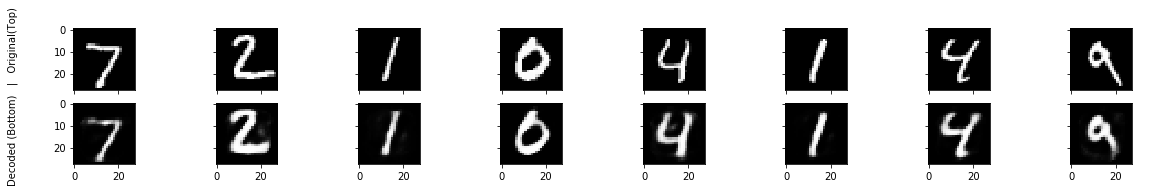

In [87]:
validate_op(8,test_images,test_output,28)